Load and pre-process ACIC data set.

In [1]:
### LINES TO IMPORT THE DECONFOUNDER PACKAGE IN THE PARENT FOLDER ###
import os
import sys
sys.path.append("..")
### IMPORTS
from deconfounder.causal_tree import CausalTree
from deconfounder.deconfounder_tree import DeconfounderTree
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time

np.random.seed(42)
# Get features
df = pd.read_csv("../data/x.csv")
df = pd.get_dummies(df)
all_feature_names = df.columns
# Merge with response info
df = pd.concat([df, pd.read_csv("../data/77/zymu_129047995.csv")], axis=1)
# Create observed response and assignment variables
df.rename(columns={"z": "z_obs"}, inplace=True)
df['effs'] = df.mu1 - df.mu0
df['y_obs'] = df.y1 * df.z_obs + df.y0 * (1 - df.z_obs)
df['z_exp'] = np.random.binomial(1, df.z_obs.mean(), df.shape[0])
df['y_exp'] = df.y1 * df.z_exp + df.y0 * (1 - df.z_exp)
# Mask to split into training and test
is_train = np.full(df.shape[0], True)
is_train[:802] = False
np.random.shuffle(is_train)

Remove features to produce unobserved confounding.

In [2]:
# Select the top 5 features that produce the most confounding
n_confounders = 5 
corr_matrix = df[all_feature_names.values.tolist() + ['z_obs', 'y_obs']].corr()
corr_matrix
ranked_features = (corr_matrix.z_obs.abs() * corr_matrix.y_obs.abs()).sort_values(ascending=False).index.values
confounders = ranked_features[~np.isin(ranked_features, ['z_obs', 'y_obs'])][:n_confounders]
feature_names = all_feature_names[~np.isin(all_feature_names, confounders)]
X = df[feature_names].copy()

Build causal tree (with cross-validation tuning) using 4,000 individuals (observational) and 1,000 individuals (experimental).

Fit causal tree with an OBSERVATIONAL data set of 4000 individuals
Best parameters set found on development set:
{'min_samples_leaf': 160}
--- Time to fit (and tune) causal tree 5.396618604660034 seconds ---
MSE of causal effect predictions: 8.97567934419504
Avg. Effect: 4.09
Avg. Estim. Effect: 5.6824065424006305
Avg. Effect with policy: 4.27
Improvement: 4.4%


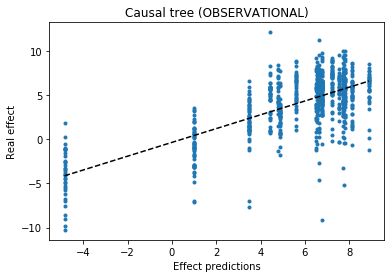





Fit causal tree with an EXPERIMENTAL data set of 1000 individuals
Best parameters set found on development set:
{'min_samples_leaf': 150}
--- Time to fit (and tune) causal tree 2.129305839538574 seconds ---
MSE of causal effect predictions: 7.746484983793969
Avg. Effect: 4.09
Avg. Estim. Effect: 3.8039386758772507
Avg. Effect with policy: 4.06
Improvement: -0.73%


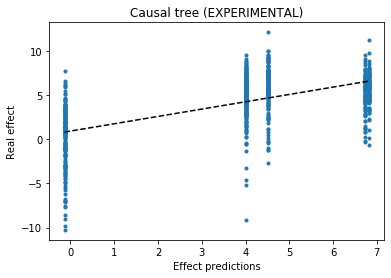

In [3]:
def fit_causal_tree(X, y):
    # Fit and tune causal tree
    start_time = time.time()
    tuned_parameters = [{'min_samples_leaf': range(10, 200, 10)}]
    causal_tree = GridSearchCV(CausalTree(random_state=42), tuned_parameters, cv=5)
    causal_tree.fit(X, y)   
    print("Best parameters set found on development set:")
    print(causal_tree.best_params_)
    print("--- Time to fit (and tune) causal tree %s seconds ---" % (time.time() - start_time))
    return causal_tree

def plot_results(preds, effs, title):
    plt.plot(preds, effs, '.')
    # Regression line
    b, m = polyfit(preds, effs, 1)
    sorted_preds = np.sort(preds)
    reg_line = b + m*sorted_preds
    plt.title(title)
    plt.xlabel("Effect predictions")
    plt.ylabel("Real effect")
    plt.plot(sorted_preds, reg_line, "--", color='black')
    print(f"MSE of causal effect predictions: {np.mean((preds - effs)**2)}")
    avg_effect = round(np.mean(effs), 2)
    avg_with_policy = round(np.mean((preds > 0) * effs), 2)
    print(f"Avg. Effect: {avg_effect}")
    print(f"Avg. Estim. Effect: {preds.mean()}")
    print(f"Avg. Effect with policy: {avg_with_policy}")
    print(f"Improvement: {round(100*avg_with_policy/avg_effect-100, 2)}%")
    plt.show()

trees = []
exp_size = 1000
for d_type in ["OBSERVATIONAL", "EXPERIMENTAL"]:
    if d_type == "OBSERVATIONAL":
        size = 4000
        y = df.y_obs
        z = df.z_obs
    else:
        print("\n\n\n")
        size = exp_size
        y = df.y_exp
        z = df.z_exp
    print(f"Fit causal tree with an {d_type} data set of {size} individuals")
    X_with_treatment = X.copy()
    X_with_treatment['treated'] = z
    causal_tree = fit_causal_tree(X_with_treatment[is_train][:size], y[is_train][:size])
    preds = causal_tree.predict(X_with_treatment[~is_train])
    plot_results(preds, df.effs[~is_train], f"Causal tree ({d_type})")
    trees.append(causal_tree)

Merge observational and experimental data.

In [4]:
np.random.seed(42)
X_all = pd.concat([X[is_train], X[is_train][:exp_size]], ignore_index=True)
X_all['experiment'] = False
X_all.loc[4000:, 'experiment'] = True
X_all['treated'] = False
X_all.loc[~X_all.experiment.values, 'treated'] = df[is_train].z_obs.values
X_all.loc[X_all.experiment.values, 'treated'] = df[is_train][:exp_size].z_exp.values
y_all = pd.concat([df[is_train].y_obs, df[is_train][:exp_size].y_exp], ignore_index=True)
X_all = X_all.sample(frac=1)
y_all = y_all.loc[X_all.index.values]

Build deconfounder tree.

In [5]:
tuned_parameters = [{'min_weight_fraction_leaf': np.array(range(5, 55, 5))/100}]
deconfounder = GridSearchCV(DeconfounderTree(random_state=42), tuned_parameters, cv=5)
deconfounder.fit(X_all, y_all)
print("Best parameters set found on development set:")
print(deconfounder.best_params_)
pd.Series(deconfounder.predict(X_all)).value_counts()

Best parameters set found on development set:
{'min_weight_fraction_leaf': 0.5}


1.273984    5000
dtype: int64

Correct confounding bias.

MSE of causal effect predictions: 6.539032026345722
Avg. Effect: 4.09
Avg. Estim. Effect: 4.408422774849306
Avg. Effect with policy: 4.33
Improvement: 5.87%


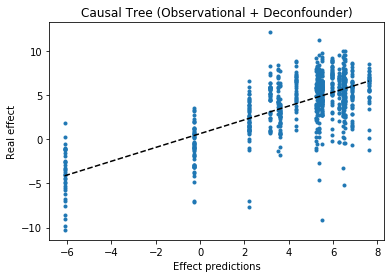

In [6]:
X_test = X[~is_train]
bias_preds = deconfounder.predict(X_test)
obs_preds = trees[0].predict(X_test)
preds = obs_preds - bias_preds
plot_results(preds, df.effs[~is_train], "Causal Tree (Observational + Deconfounder)")